In [2]:
# check for cuda
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import time
import copy
import argparse
import ast
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from scipy.sparse import lil_matrix
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim

# check for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
%%time
# Load the CSV file and extract the Description column
data = pd.read_csv('ANLP-2/train.csv')
corpus = data['Description']
sentence_count= 0
sentence_limit = 400
sentences_list = []

for sentence in corpus:
    sentences_list.append(sentence)
    sentence_count += 1
    if sentence_count > sentence_limit:
        break

word_counts = {}
text_courpus = []
MinWords = 40000 # min words in a sentence
minSentenceLength = 500 # min words in a sentence
for sentence in sentences_list:
    sentence = sentence.lower() # convert to lower case
    sentence = re.sub(r'[^\w\s]', '', sentence) # remove punctuation
    text_courpus.append(sentence)
    words = sentence.split()
    minSentenceLength = min(minSentenceLength, len(words))
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1


CPU times: user 369 ms, sys: 52.3 ms, total: 421 ms
Wall time: 435 ms


In [4]:
%%time

# Dealing with the '<UNK>' word

num_min_words = 0
for word in word_counts:
    if word_counts[word] <= 3:
        num_min_words += 1
word_counts['<UNK>'] = num_min_words

word_counts = {k : v for k, v in word_counts.items() if v > 3}

CPU times: user 698 µs, sys: 0 ns, total: 698 µs
Wall time: 702 µs


In [59]:
%%time

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print (f'Using {device} device')

Using cuda device
CPU times: user 40 µs, sys: 20 µs, total: 60 µs
Wall time: 62.5 µs


In [5]:
def create_lookup_tables(word_counts):
    """
    Create lookup tables for vocabulary
    - words: list of words
    - return: 2 dictionaries, vocab_to_int, int_to_vocab
    """
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [6]:
vocab_to_int, int_to_vocab = create_lookup_tables(word_counts)
int_words = [vocab_to_int[word] for word in words]

KeyError: 'ring'

## 4. Perform Word Subsampling
Removing those words like of, for which posses no much context meaning

In [64]:
import random
import numpy as np

def subsample_words(int_words, threshold = 1e-5):
  word_counts = Counter(int_words)
  total_n_words = len(int_words)

  freq_ratios = {word: count/total_n_words for word, count in word_counts.items()}
  p_drop = {word: 1 - np.sqrt(threshold/freq_ratios[word]) for word in word_counts}

  return [word for word in int_words if random.random() < (1 - p_drop[word])]


In [30]:
relevant_words = subsample_words(word_counts)
word_freq = {}
for word in relevant_words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1


In [38]:
# print 5 most frequent words
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:50])

[('investment', 1), ('in', 1), ('the', 1), ('bets', 1), ('on', 1), ('market', 1), ('crude', 1), ('week', 1), ('pipeline', 1), ('showed', 1), ('rebel', 1), ('militia', 1), ('saturday', 1), ('months', 1), ('higher', 1), ('year', 1), ('as', 1), ('mutual', 1), ('by', 1), ('latest', 1), ('sales', 1), ('last', 1), ('indicating', 1), ('is', 1), ('work', 1), ('manager', 1), ('about', 1), ('furthest', 1), ('says', 1), ('do', 1), ('markets', 1), ('governor', 1), ('record', 1), ('president', 1), ('washingtonnew', 1), ('auction', 1), ('incs', 1), ('rocky', 1), ('broadly', 1), ('june', 1), ('if', 1), ('may', 1), ('need', 1), ('relatives', 1), ('their', 1), ('dont', 1), ('phenomenon', 1), ('these', 1), ('who', 1), ('stuck', 1)]


### generate TArgets

In [65]:
import random
def get_target(words, idx, max_window_size=5):
    R = random.randint(1, max_window_size)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

Generate batches


In [45]:
def get_batches(words, batch_size, max_window_size=5):
  # only full batches
  n_batches = len(words)//batch_size
  words = words[:n_batches*batch_size]
  for i in range(0, len(words), batch_size):
    batch_of_center_words = words[i:i+batch_size]   # current batch of words
    batch_x, batch_y = [], []  

    for ii in range(len(batch_of_center_words)):  # range(batch_size) unless truncated at the end
      x = [batch_of_center_words[ii]]             # single word
      y = get_target(words=batch_of_center_words, idx=ii, max_window_size=max_window_size)  # list of context words

      batch_x.extend(x * len(y)) # repeat the center word (n_context_words) times
      batch_y.extend(y)
  
    yield batch_x, batch_y   

In [67]:
import torch
import torch.nn as nn

class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegativeSampling, self).__init__()
        # Initialize word embeddings for input words
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Initialize word embeddings for output (context) words
        self.out_embedding = nn.Embedding(vocab_size, embedding_dim)
        # Define the LogSigmoid activation function
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, input_words, target_words, negative_words):
        # Get embeddings for input words (center words)
        input_embeds = self.embedding(input_words)  # shape: (batch_size, embedding_dim)
        # Get embeddings for target words (context words)
        target_embeds = self.out_embedding(target_words)  # shape: (batch_size, embedding_dim)
        # Get embeddings for negative samples
        neg_embeds = -self.out_embedding(negative_words)  # shape: (batch_size, num_negs, embedding_dim)

        # Compute dot product of input and output embeddings for positive samples
        positive_score = torch.sum(input_embeds * target_embeds, dim=1)  # shape: (batch_size,)
        # Compute dot product of input embeddings and negative embeddings for negative samples
        negative_score = torch.sum(input_embeds.unsqueeze(1) * neg_embeds, dim=2)  # shape: (batch_size, num_negs)
        
        # Compute loss using LogSigmoid for positive and negative samples
        loss = self.log_sigmoid(positive_score) + torch.sum(self.log_sigmoid(negative_score), dim=1)  # shape: (batch_size,)
        # Return the negative of the mean of the loss (minimizing loss is the objective)
        return -torch.mean(loss)
 


Cosine

In [66]:
import torch
import random
import numpy as np

def compute_cosine_similarity(embedding_module, num_valid_words=16, valid_window=100):
    """Calculate cosine similarity between validation words and words in the embedding matrix.
    
    Args:
    - embedding_module: PyTorch embedding module
    - num_valid_words: Number of validation words (recommended to be even)
    - valid_window: Window size for selecting validation words
    
    Returns:
    - valid_word_indices: Indices of validation words in the embedding matrix
    - similarities: Cosine similarities between validation words and all words in the embedding matrix
    """
    # Get all embeddings from the embedding matrix
    all_word_embeddings = embedding_module.weight  # Shape: (vocab_size, embedding_dim)
    
    # Calculate magnitudes for normalization
    magnitudes = torch.sqrt(torch.sum(all_word_embeddings.pow(2), dim=1)).unsqueeze(0)  # Shape: (1, vocab_size)
    
    # Select validation words from two ranges: common words and uncommon words
    selected_valid_words = random.sample(range(valid_window), num_valid_words // 2) + \
                           random.sample(range(1000, 1000 + valid_window), num_valid_words // 2)
    valid_word_indices = torch.LongTensor(np.array(selected_valid_words)).to(all_word_embeddings.device)  # Convert to tensor
    
    # Get embeddings for validation words
    valid_word_embeddings = embedding_module(valid_word_indices)  # Shape: (num_valid_words, embedding_dim)
    
    # Calculate cosine similarities
    similarities = torch.mm(valid_word_embeddings, all_word_embeddings.t()) / magnitudes  # Shape: (num_valid_words, vocab_size)
    
    return valid_word_indices, similarities


Defingin skip gram

In [68]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        

    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors  # input vector embeddings
    

    def forward_target(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors  # output vector embeddings
    

    def forward_noise(self, batch_size, n_samples=5):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        # If no Noise Distribution specified, sample noise words uniformly from vocabulary
        if self.noise_dist is None:
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # torch.multinomial :
        # Returns a tensor where each row contains (num_samples) **indices** sampled from 
        # multinomial probability distribution located in the corresponding row of tensor input.
        noise_words = torch.multinomial(input       = noise_dist,           # input tensor containing probabilities
                                        num_samples = batch_size*n_samples, # number of samples to draw
                                        replacement = True)
        noise_words = noise_words.to(device)
        
        # use context matrix for embedding noise samples
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

In [69]:

class NegativeSamplingLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, 
              input_vectors, 
              output_vectors, 
              noise_vectors):
      
    batch_size, embed_size = input_vectors.shape
    
    input_vectors = input_vectors.view(batch_size, embed_size, 1)   # batch of column vectors
    output_vectors = output_vectors.view(batch_size, 1, embed_size) # batch of row vectors
    
    # log-sigmoid loss for correct pairs
    out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()
    
    # log-sigmoid loss for incorrect pairs
    noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
    noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

    return -(out_loss + noise_loss).mean()  # average batch loss

In [70]:
# As defined in the paper by Mikolov et all.
freq = Counter(int_words)
freq_ratio = {word:cnt/len(vocab_to_int) for word, cnt in freq.items()}        
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum() 
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

In [71]:
from torch import optim

embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), 
                                 embedding_dim, 
                                 noise_dist )
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [77]:
def train_skipgram(model,criterion,optimizer,int_words,n_negative_samples=5,batch_size=512,
                   n_epochs=5,print_every=1500,):
  model.to(device)
  
  step = 0
  for epoch in range(n_epochs):
    for inputs, targets in get_batches(int_words, batch_size=batch_size):
      step += 1
      inputs = torch.LongTensor(inputs).to(device)    # [b*n_context_words]
      targets = torch.LongTensor(targets).to(device)  # [b*n_context_words]
      
      embedded_input_words = model.forward_input(inputs)
      embedded_target_words = model.forward_target(targets)
      embedded_noise_words = model.forward_noise(batch_size=inputs.shape[0], 
                                                  n_samples=n_negative_samples)

      loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if (step % print_every) == 0:
        print("Epoch: {}/{}".format((epoch+1), n_epochs))
        print("Loss: {:.4f}".format(loss.item()))
        valid_idxs, similarities = cosine_similarity(model.in_embed)
        _, closest_idxs = similarities.topk(6)
        valid_idxs, closest_idxs = valid_idxs.to('cpu'), closest_idxs.to('cpu')
        
        for ii, v_idx in enumerate(valid_idxs):
          closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
          print(int_to_vocab[v_idx.item()] + " | "+ ", ".join(closest_words))

        print("\n...\n")

In [78]:
train_skipgram(model,criterion,optimizer,int_words,n_negative_samples=5)

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

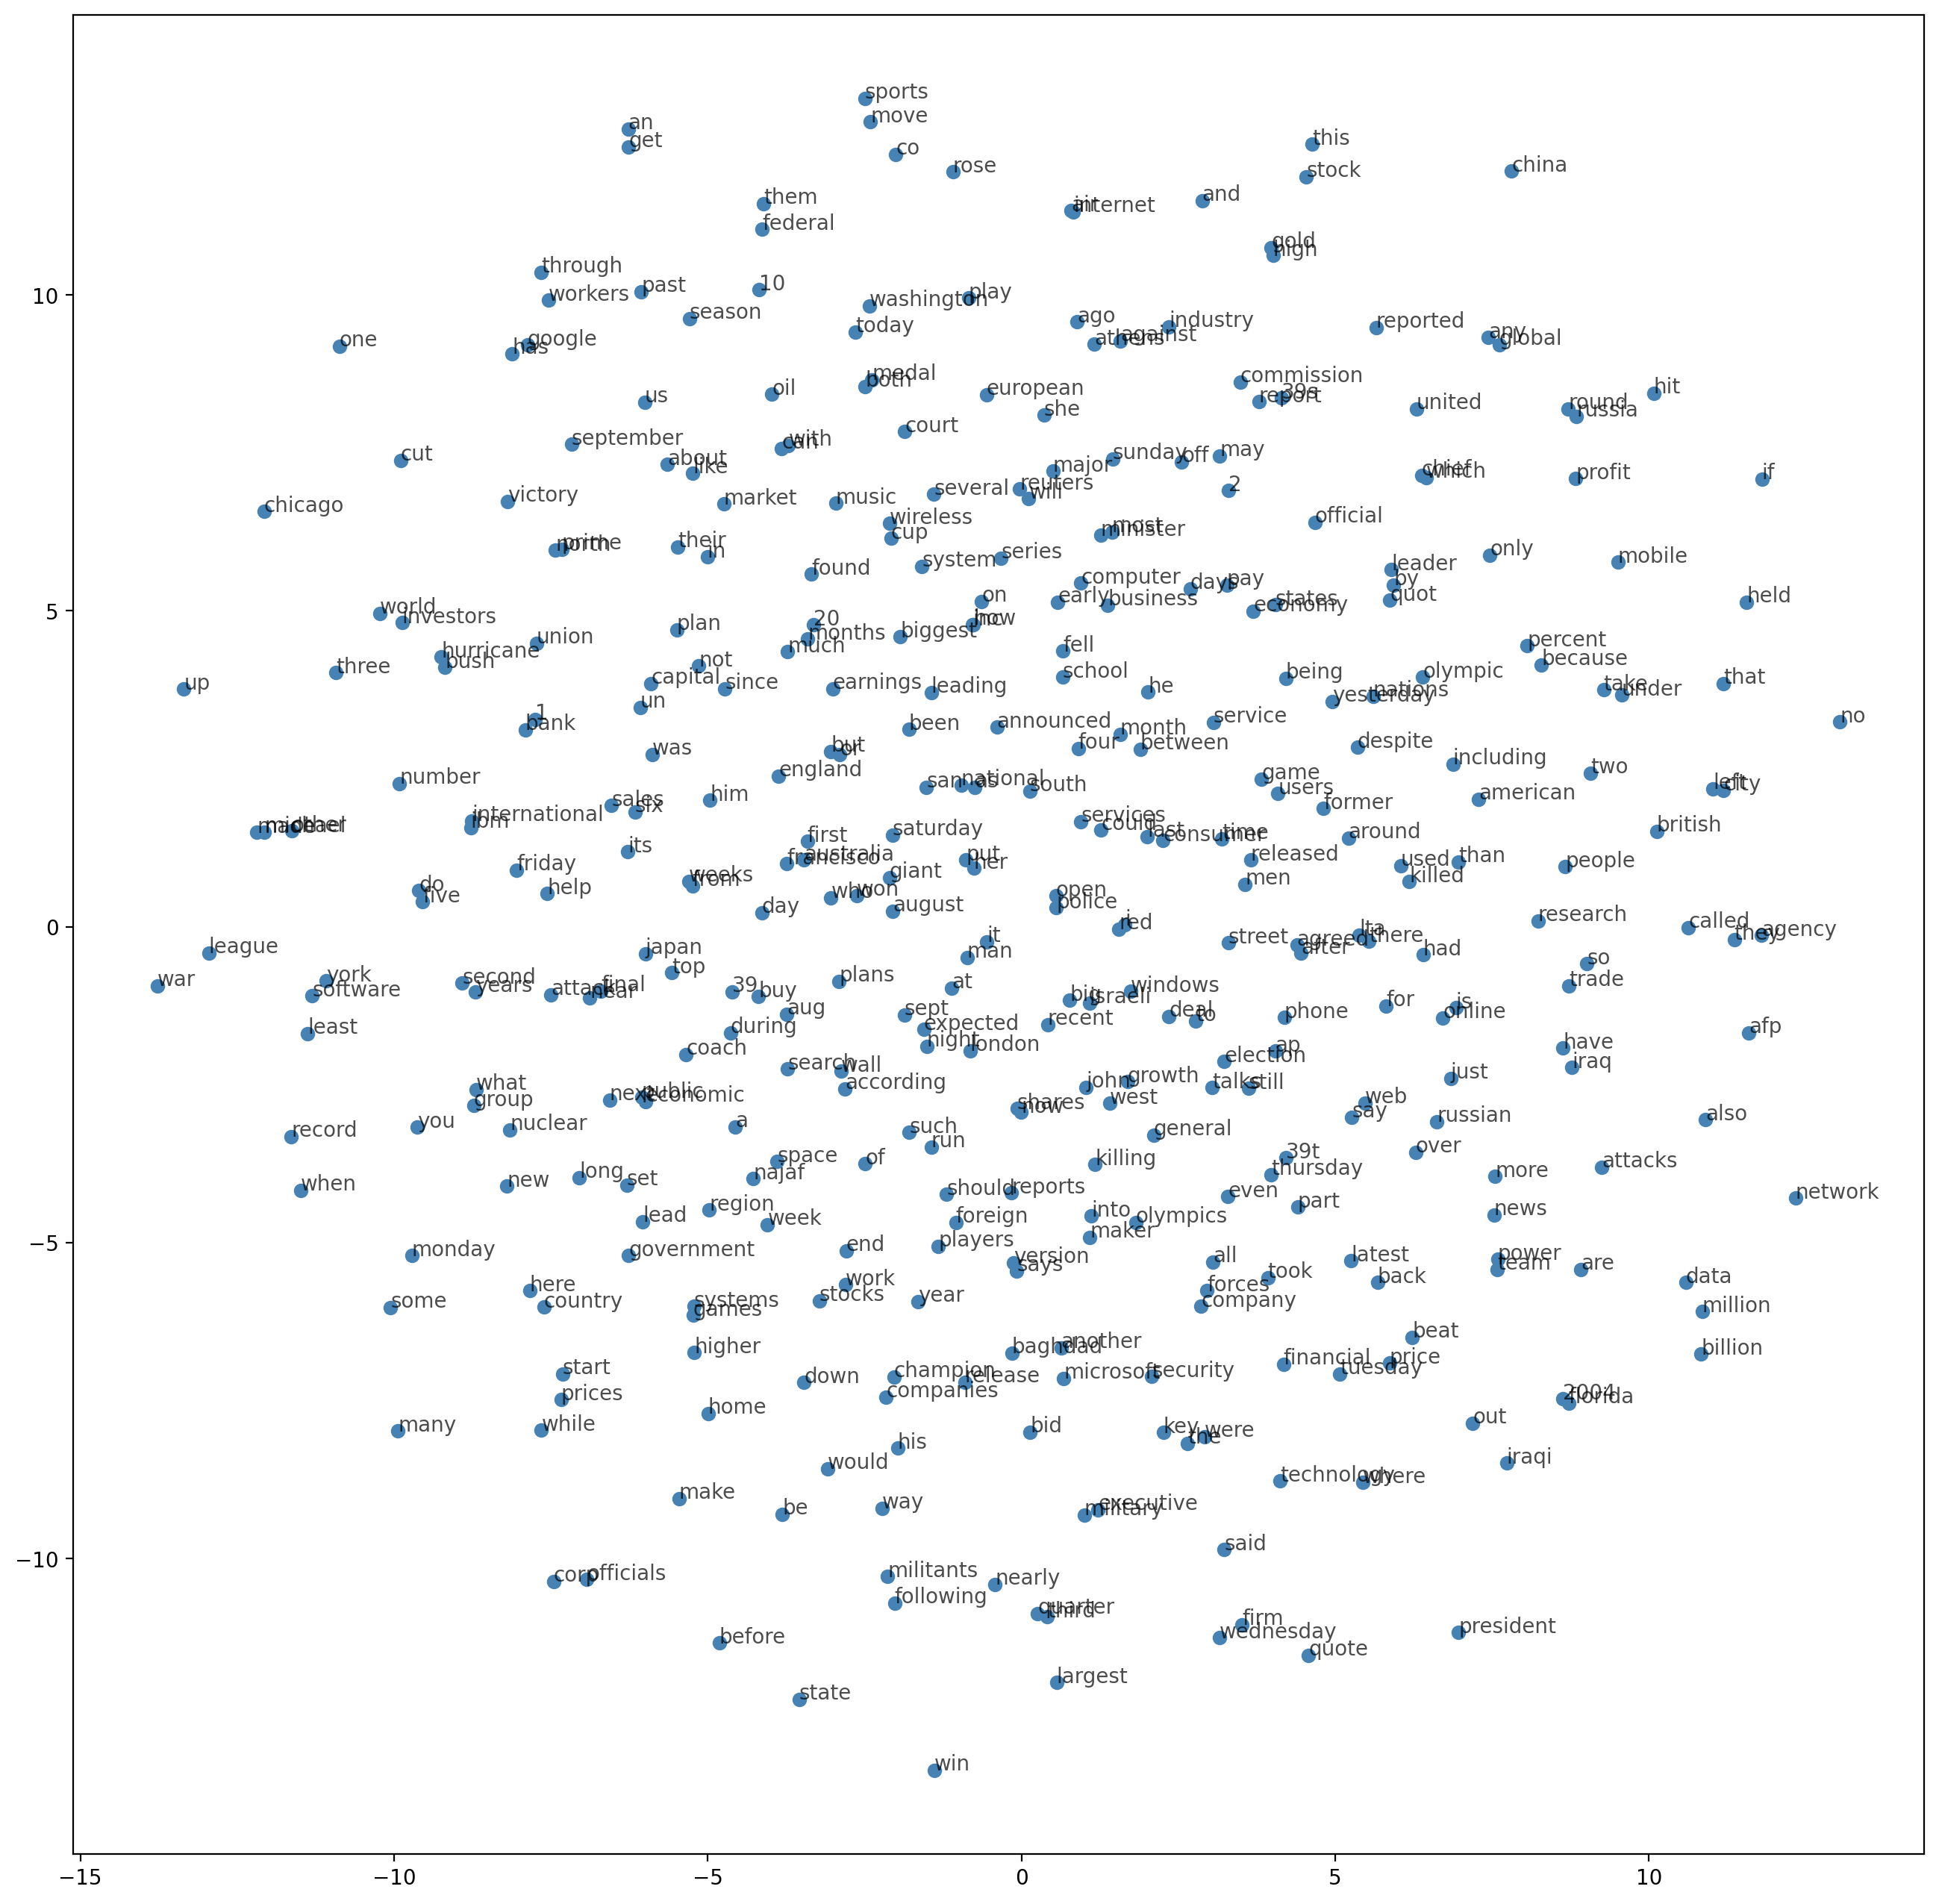

In [80]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)